# Setup

### Mount Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive',force_remount=True)

### Path to training data on drive

In [2]:
path_folder = "../splits_final_deblurred/"

### Imports

In [3]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
#import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, concatenate, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from keras.activations import softmax
from keras.layers import concatenate
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input
from keras.models import Model
import sys
import cv2
# sys.path.append("/content/gdrive/My Drive/Colab Notebooks/Project/")

import os
from PIL import Image

### Helper Functions

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

num_classes = 5
class_names = ["background", "rigid_plastic", "cardboard", "metal", "soft_plastic"]
class_colors = [[0,0,0], [0,0,255], [0,255,0], [255,0,0] ,[125,0,125]]

def Make_Overlapping_Plot2(image, label=None, pred=None):
    '''
    Makes one/two/three plots, first is the image, the others are segmentation/predicitons combined with image where background is unchanged, all other classes
    have a color.
    \n RED: Rigid Plastic
    \n GREEN: Cardboard
    \n BLUE: Metal
    \n PURPLE: Soft plastic.
    '''
    _, ax1 = plt.subplots()
    ax1.set_title("Image")
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if label is not None:
      red = np.where(label[:,:,1] == 1)
      green = np.where(label[:,:,2] == 1)
      blue = np.where(label[:,:,3] == 1)
      purple = np.where(label[:,:,4] == 1)
      image2 = np.copy(image)
      image2[red] = class_colors[1]
      image2[green] = class_colors[2]
      image2[blue] = class_colors[3]
      image2[purple] = class_colors[4]
      _, ax2 =plt.subplots()
      ax2.set_title("Overlapping Labels")
      ax2.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

    if pred is not None:
      image3 = np.copy(image)
      red = np.where(pred[:,:,1] >= 0.5)
      green = np.where(pred[:,:,2] >= 0.5)
      blue = np.where(pred[:,:,3] >= 0.5)
      purple = np.where(pred[:,:,4] >= 0.5)
      image3[red] = class_colors[1]
      image3[green] = class_colors[2]
      image3[blue] = class_colors[3]
      image3[purple] = class_colors[4]
      _, ax3 =plt.subplots()
      ax3.set_title("predictions")
      ax3.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))

    plt.show()
    return 0


In [5]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
from PIL import Image

def create_y_labels(loaded_labels, y_labels):
  if loaded_labels.ndim == 3:
    for i in range(0,y_labels.shape[0]):
      background = np.where(loaded_labels[i,:,:] == 0)
      red = np.where(loaded_labels[i,:,:] == 1)
      green = np.where(loaded_labels[i,:,:] == 2)
      blue = np.where(loaded_labels[i,:,:] == 3)
      purple = np.where(loaded_labels[i,:,:] == 4)
      y_labels[i,:,:,0][background] = 1 #Background
      y_labels[i,:,:,1][red] = 1        #Rigid Plast
      y_labels[i,:,:,2][green] = 1      #Cardboard
      y_labels[i,:,:,3][blue] = 1       #Metal
      y_labels[i,:,:,4][purple] = 1     #SoftPlast
  else:
    for i in range(0,y_labels.shape[0]):
      background = np.where(loaded_labels[i,:,:,0] == 0)
      red = np.where(loaded_labels[i,:,:,0] == 1)
      green = np.where(loaded_labels[i,:,:,0] == 2)
      blue = np.where(loaded_labels[i,:,:,0] == 3)
      purple = np.where(loaded_labels[i,:,:,0] == 4)
      y_labels[i,:,:,0][background] = 1 #Background
      y_labels[i,:,:,1][red] = 1        #Rigid Plast
      y_labels[i,:,:,2][green] = 1      #Cardboard
      y_labels[i,:,:,3][blue] = 1       #Metal
      y_labels[i,:,:,4][purple] = 1     #SoftPlast
  return y_labels


# Model

Loss function

In [6]:
import keras.backend as K

def dice_coef(y_true, y_pred):
  y_true = tf.reshape(tf.cast(y_true, tf.float64), [-1])
  y_pred = tf.reshape(tf.cast(y_pred, tf.float64), [-1])
  intersection = K.sum(y_true * y_pred)
  union = K.sum(y_true) + K.sum(y_pred)
  epsilon = 1e-4
  return (2*intersection + epsilon)/(union+epsilon)

def dice_loss_function(y_true, y_pred):
  coef = 0.
  for i in range(5):
    coef += dice_coef(y_true[:,:,:,i], y_pred[:,:,:,i])
  return 1-coef/5.

Similar to the model described in https://qims.amegroups.org/article/view/91409/pdf , page 3143, figure 3(b)

In [7]:
from keras.layers import concatenate, BatchNormalization
from keras.layers import UpSampling2D
from keras.activations import softmax
from keras.applications.vgg16 import preprocess_input
input_dim = (224, 224)

# See last layer of network
def softMaxAxis3(x):
    return softmax(x,axis=3)

def my_conv(x,filters,kernel_size=3,padding='same',kernel_initializer='he_normal'):
  x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer, strides=1)(x)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def apply_tensor_to_layers(x, layers):
  for l in layers:
    x = l(x)
  return x

vgg16 = keras.applications.VGG16(weights="imagenet",input_shape=(*input_dim, 3), include_top=False)
inputs = keras.Input(shape=(*input_dim, 3))
x = preprocess_input(inputs)  #shifts from RBG to BGR and zero centers pixels, BGR mean values = [-103.93900299, -116.77899933, -123.68000031]
x = vgg16.layers[1](x, training=False)

# create vgg16 encoder while remembering connections for concatenation
con1 = apply_tensor_to_layers(x, vgg16.layers[2:4])
con2 = apply_tensor_to_layers(con1, vgg16.layers[4:7])
con3 = apply_tensor_to_layers(con2, vgg16.layers[7:11])
con4 = apply_tensor_to_layers(con3, vgg16.layers[11:15])
encoder =  apply_tensor_to_layers(con4, vgg16.layers[15:19])

# decoder
up1 = UpSampling2D((2,2))(encoder)
concat4 = concatenate([up1, con4], axis=3)
up2 = my_conv(concat4, filters=256)

up2 = UpSampling2D((2,2))(up2)
concat3 = concatenate([up2, con3], axis=3)
up3 = my_conv(concat3, filters=128)

up3 = UpSampling2D((2,2))(up3)
concat2 = concatenate([up3, con2], axis=3)
up4 = my_conv(concat2, filters=64)

up4 = UpSampling2D((2,2))(up4)
concat1 = concatenate([up4, con1], axis=3)
up5 = my_conv(concat1, filters=32)

up5 = UpSampling2D((2,2))(up5)
#decoder = my_conv(up5, filters=5)
decoder = Conv2D(num_classes, 1, activation = softMaxAxis3)(up5)
# Model
model_ = Model(inputs, decoder)
model = Model(inputs, decoder)

#set vgg16 layers to not trainable
for i in range(19):
  model.layers[i].trainable = False

model.compile(optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = 0.01), loss = dice_loss_function)

2023-12-07 11:52:48.814768: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-07 11:52:48.814791: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-07 11:52:48.814794: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-07 11:52:48.814845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 11:52:48.815160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 224, 224, 3)          0         ['input_2[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                                                                                            

# Experiment of cropping randomly

## Data Generator

### Cropping function

In [9]:
from itertools import cycle
from scipy import ndimage

def crop_randomly_single(data, seg, dim):
  w, h, d = data.shape
  result_data = np.zeros((*dim, d), np.uint8)
  result_seg = np.zeros((*dim, num_classes), np.float32)
  x = np.random.randint(0,w-dim[0])
  y = np.random.randint(0,h-dim[1])
  result_data = data[x:x+dim[0], y:y+dim[1], :]
  result_seg = seg[x:x+dim[0], y:y+dim[1], :]

  return result_data, result_seg

### Generator implementation

In [10]:
import numpy as np
import keras
import os
from PIL import Image
import cv2

# implementation from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# with specific changes to fit this experiment
class DataGenerator(keras.utils.Sequence):
    def __init__(self, base_path, data, batch_size=32, dim=(240, 360), n_channels=3, n_classes=5, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.base_path = base_path
        self.indexes = np.array(1)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))
        #return 2

    def __getitem__(self, index):
        'Make one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data_temp = [self.data[i] for i in indexes]
        x, y = self.__data_generation(data_temp)
        return x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, data):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels), dtype=np.float32)
        # Generate data
        for i, file_name in enumerate(data):
          image_path = os.path.join(self.base_path, 'data', file_name)
          seg_path = os.path.join(self.base_path, 'sem_seg', file_name)
          try:
              # Open and load the image
              img_data = cv2.imread(image_path)
              img_seg = cv2.imread(seg_path)
              cropped_img_data,cropped_img_seg =  crop_randomly_single(img_data, img_seg, self.dim)
              x[i] = np.array(cropped_img_data)
              y[i] = np.array(cropped_img_seg)

          except Exception as e:
              print(f"Error loading {image_path}: {str(e)}")

        x = np.array(x, dtype=np.float32)
        y = create_y_labels(y, np.zeros((self.batch_size, self.dim[0], self.dim[1], self.n_classes), dtype=np.float32))
        return x, y

### Load image file information including paths

In [11]:
import json
import cv2
import numpy as np

def load_and_extract_ids(folder_path, data_type):
    file_path = f"{folder_path}/{data_type}/labels.json"

    with open(file_path) as file:
        data_loader = json.load(file)
    images = data_loader["images"]
    print(len(images))
    image_paths = []
    for i in range(0,len(images)):
      image_paths.append(images[i]['file_name'])
    return image_paths

# Load and extract IDs for train, validation, and test sets
train_ids = load_and_extract_ids(path_folder, "train")
validation_ids = load_and_extract_ids(path_folder, "val")
test_ids = load_and_extract_ids(path_folder, "test")

3002
572
929


### Create DataGenerator Instance

In [12]:
params = {'dim': input_dim,
          'batch_size': 32,
          'n_classes': 5,
          'n_channels': 3,
          'shuffle': True}

partition = {
    'train': train_ids,
    'val': validation_ids,
    'test': test_ids
}


training_generator = DataGenerator(base_path = path_folder + 'train/', data = partition['train'], **params)
validation_generator = DataGenerator(base_path = path_folder + 'val/', data = partition['val'], **params)
test_generator = DataGenerator(base_path = path_folder + 'test/', data = partition['test'], **params)

## Training

In [13]:
def our_learning_rate(epoch, learning_rate):
  if epoch == 0:
    return 0.01
  return learning_rate * tf.math.exp(-0.10)

callback = keras.callbacks.LearningRateScheduler(our_learning_rate)
history = model.fit(training_generator, validation_data=validation_generator, epochs=20, callbacks = [callback], verbose=1)

Epoch 1/20


2023-12-07 11:52:51.654839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 180s 2s/step - loss: 0.8093 - val_loss: 0.7847 - lr: 0.0100
Epoch 2/20
93/93 [==============================] - 177s 2s/step - loss: 0.7651 - val_loss: 0.7304 - lr: 0.0090
Epoch 3/20
93/93 [==============================] - 177s 2s/step - loss: 0.7200 - val_loss: 0.7124 - lr: 0.0082
Epoch 4/20
93/93 [==============================] - 176s 2s/step - loss: 0.7100 - val_loss: 0.7166 - lr: 0.0074
Epoch 5/20
93/93 [==============================] - 180s 2s/step - loss: 0.6999 - val_loss: 0.6883 - lr: 0.0067
Epoch 6/20
93/93 [==============================] - 177s 2s/step - loss: 0.6952 - val_loss: 0.6971 - lr: 0.0061
Epoch 7/20
93/93 [==============================] - 173s 2s/step - loss: 0.6890 - val_loss: 0.6956 - lr: 0.0055
Epoch 8/20
93/93 [==============================] - 173s 2s/step - loss: 0.6866 - val_loss: 0.6887 - lr: 0.0050
Epoch 9/20
93/93 [==============================] - 171s 2s/step - loss: 0.6859 - val_loss: 0.6860 - lr: 0.0045
Epo

### Plot

dict_keys(['loss', 'val_loss', 'lr'])


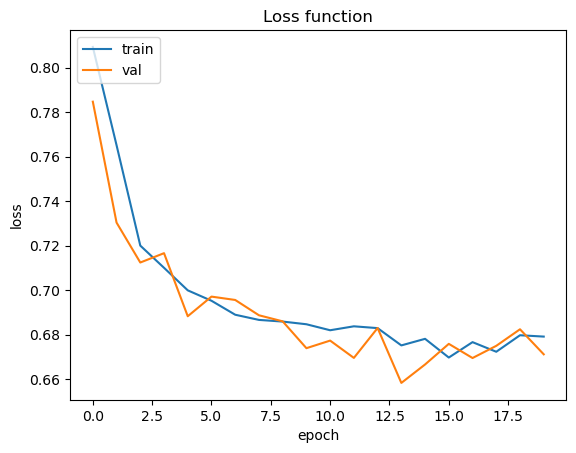

In [14]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test

In [15]:
x_test, y_test = test_generator[0]
for i in range(1, 5):
  print(i)
  x_temp, y_temp = test_generator[i]
  x_test, y_test = np.vstack((x_test,x_temp)), np.vstack((y_test, y_temp))
print(x_test.shape)
print(y_test.shape)

pred = model.predict(x_test)

1
2
3
4
(160, 224, 224, 3)
(160, 224, 224, 5)
5/5 [==============================] - 3s 632ms/step


### Dice coefficient

In [16]:
print("Dice coefficient: \t" +  '{:.4}'.format(dice_coef(y_test, pred)))
print("Dice loss function: \t" + '{:.4}'.format(dice_loss_function(y_test, pred)))
print(dice_coef(y_test, y_test))
def dice_coef2(y, pred):
  coef = 0
  for i in range(y.shape[3]):
    intersection = np.sum(y[:,:,:,i] * pred[:,:,:,i])
    set_size = np.sum(y[:,:,:,i]) + np.sum(pred[:,:,:,i])
    coef += (2*intersection)/set_size
  return coef/5.0

print(dice_coef2(y_test, pred))
print(dice_loss_function(tf.constant(y_test), tf.constant(pred)))

Dice coefficient: 	0.8117
Dice loss function: 	0.6498
tf.Tensor(1.0, shape=(), dtype=float64)
0.3502022164372437
tf.Tensor(0.649797755575185, shape=(), dtype=float64)


### IoU

In [17]:
class_names = ["background", "rigid_plastic", "cardboard", "metal", "soft_plastic"]
def mean_intersection_over_union(y, pred):
    result = 0
    for i in range(num_classes):
        intersection = np.sum(y[:,:,:,i]*pred[:,:,:,i])
        union = np.sum(y[:,:,:,i]) + np.sum(pred[:,:,:,i]) - intersection
        print("IoU of " + class_names[i] + " is " + '{:.4}'.format(100*intersection/union))
        result += intersection/union
    return result/num_classes
print("mean intersection over union is " + '{:.4}'.format(100*mean_intersection_over_union(y_test, pred)))

IoU of background is 80.89
IoU of rigid_plastic is 0.7241
IoU of cardboard is 42.87
IoU of metal is 1.799
IoU of soft_plastic is 11.53
mean intersection over union is 27.56


### Percentage of pixels categorized correctly




In [18]:
# Calculation of the percentage of pixels that are categorized correctly
y_pred_binary = np.argmax(pred, axis=3).flatten()
correct_predictions2 = np.sum(np.equal(y_pred_binary, np.argmax(y_test, axis=3).flatten()))
n, h, w, _ = y_test.shape
pixels = n*h*w
accuracy = correct_predictions2 / pixels * 100.0
print("acuracy is "  + '{:.4}'.format(accuracy))

acuracy is 81.17


### Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix

#See lab 4 for explanation of Confusion Matrix
pred_flat = np.array([])
image_labels_flat = np.array([])
print(pred.shape)
for i in range(pred.shape[0]):
  image_predictions = np.argmax(pred[i], axis=2).flatten()
  pred_flat = np.hstack([pred_flat,image_predictions])
  img_labels = np.argmax(y_test[i], axis=2).flatten()
  image_labels_flat = np.hstack([image_labels_flat, img_labels])


image_labels_flat = np.hstack([image_labels_flat, np.arange(5)])
pred_flat = np.hstack([pred_flat, np.arange(5)])
conf_matrix = confusion_matrix(image_labels_flat, pred_flat)
print("1: background 2: rigid_plastic 3: cardboard 4: metal 5: soft_plastic\n")
print("Confusion Matrix")
print(conf_matrix-np.eye(5, dtype=np.int64))

np.set_printoptions(precision=2)
conf_matrix_norm = ((conf_matrix.T-np.eye(5, dtype=np.int64)) / np.sum(conf_matrix, axis=1)).T
print("\nNormalized Confusion Matrix")
print(np.round(conf_matrix_norm,3)*100)

(160, 224, 224, 5)
1: background 2: rigid_plastic 3: cardboard 4: metal 5: soft_plastic

Confusion Matrix
[[5840205   62327  295896   30951  280117]
 [  80396    1436    4327    4098   34770]
 [ 415565    7912  596811   10832   21289]
 [   5891     224     552    1068    4144]
 [ 208159    3217   38982    1779   77212]]

Normalized Confusion Matrix
[[89.7  1.   4.5  0.5  4.3]
 [64.3  1.1  3.5  3.3 27.8]
 [39.5  0.8 56.7  1.   2. ]
 [49.6  1.9  4.6  9.  34.9]
 [63.2  1.  11.8  0.5 23.4]]


### Precision and Recall

In [20]:

show_interesting_facts = False
if show_interesting_facts:
  print("------------------------------ interesting facts ----------------------------------------")
  print("percentage of pixels that are cardboard in training set: " + '{:.4}'.format(100*np.sum(conf_matrix[2,:])/np.sum(conf_matrix)))
  print("percentage of pixels that are background in training set: " + '{:.4}'.format(100*np.sum(conf_matrix[0,:])/np.sum(conf_matrix)) + " and accuracy is " + '{:.4}'.format(accuracy))
  print("Therefore the model is "  + '{:.4}'.format(accuracy - 100*np.sum(conf_matrix[0,:])/np.sum(conf_matrix)) + " percentage points better in accuracy than always guessing background")
  print("\npercentage of time the model guesses background: " + '{:.4}'.format(100*np.sum(conf_matrix[:,0])/np.sum(conf_matrix)))
  print("percentage of time the model guesses cardboard: " + '{:.4}'.format(100*np.sum(conf_matrix[:,2])/np.sum(conf_matrix)))

  print("\n----------------------------------------------------------------------------------------")
classes = ["background", "rigid plastic", "cardboard", "metal\t", "soft plastic"]
print("Precision with regards to each class:\n")
conf_matrix = conf_matrix - np.eye(5, dtype=np.int64)
for i in range(len(classes)):
  if np.sum(conf_matrix[:,i]) == 0:
    print( classes[i] + ": \t" + "no predictions")
  else:
    precision = 100*conf_matrix[i,i]/np.sum(conf_matrix[:,i])
    print( classes[i] + ": \t" + '{:.4}'.format(precision))

# This is also just the diagonal of the normalized confusion matrix
print("\nRecall with regards to each class:\n")
for i in range(len(classes)):
  if np.sum(conf_matrix[i,:]) == 0:
    print(classes[i] + ": \t" + "no predictions")
  else:
    recall = 100*conf_matrix[i,i]/np.sum(conf_matrix[i,:])
    print(classes[i] + ": \t" + '{:.4}'.format(recall))

Precision with regards to each class:

background: 	89.16
rigid plastic: 	1.912
cardboard: 	63.72
metal	: 	2.192
soft plastic: 	18.49

Recall with regards to each class:

background: 	89.72
rigid plastic: 	1.149
cardboard: 	56.71
metal	: 	8.991
soft plastic: 	23.44


### Visual inspection

------------------------------------------------------------
For test imgages #1


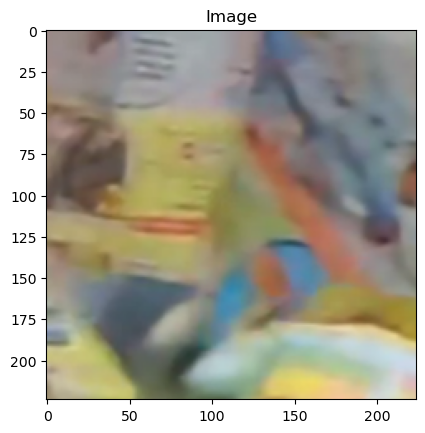

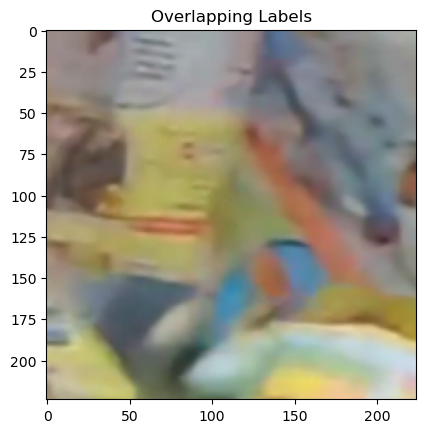

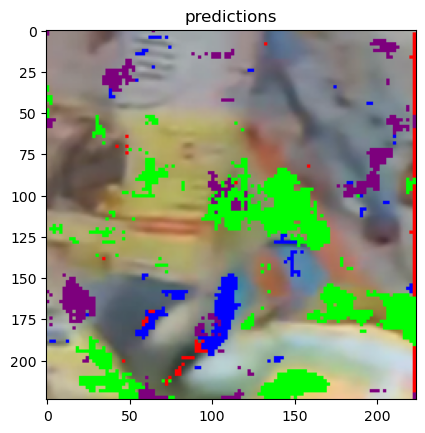

------------------------------------------------------------
For test imgages #11


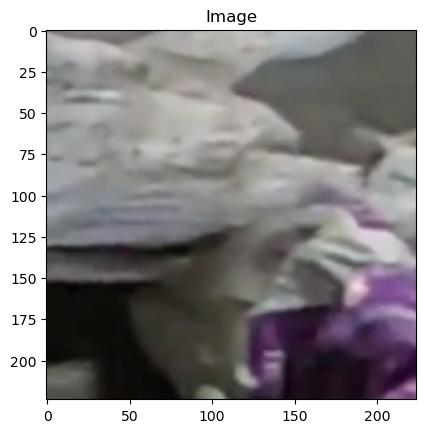

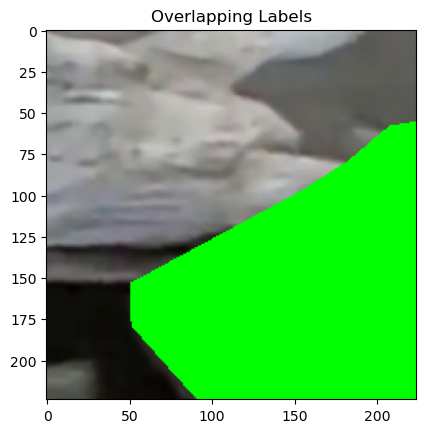

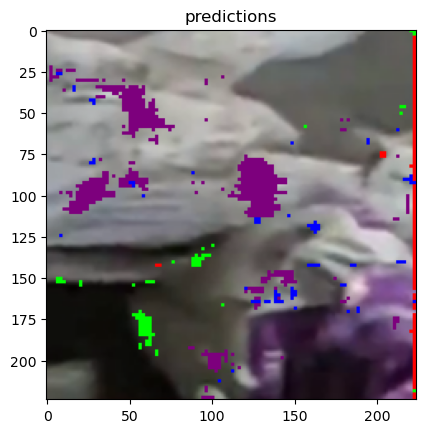

------------------------------------------------------------
For test imgages #21


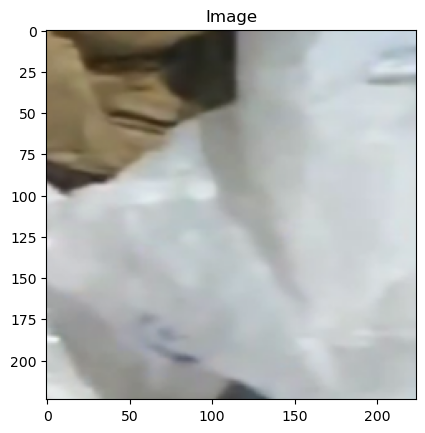

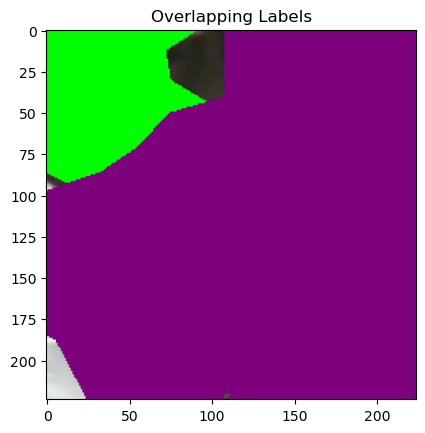

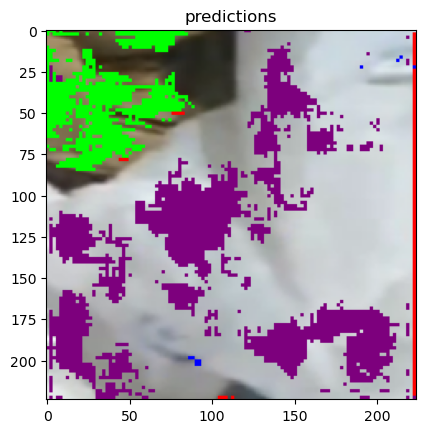

------------------------------------------------------------
For test imgages #31


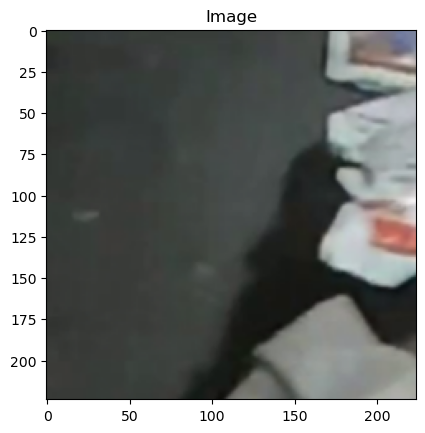

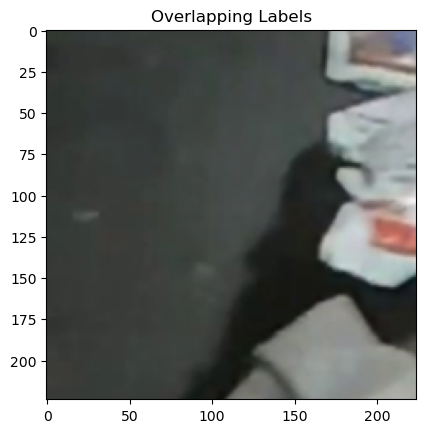

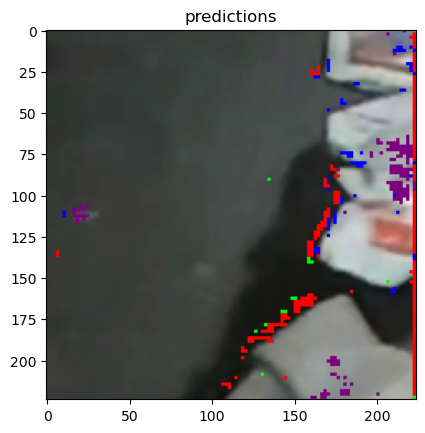

------------------------------------------------------------
For test imgages #41


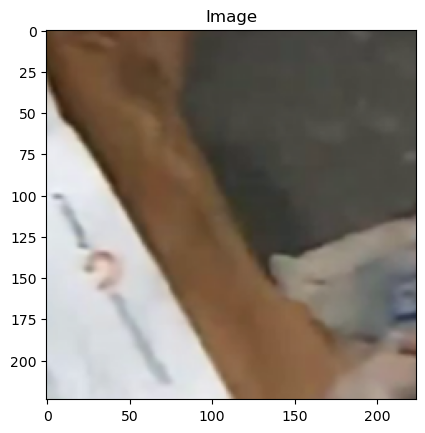

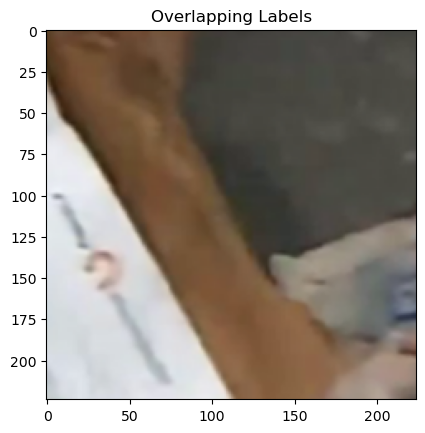

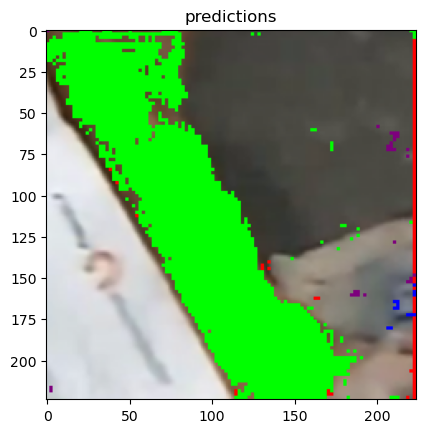

------------------------------------------------------------
For test imgages #51


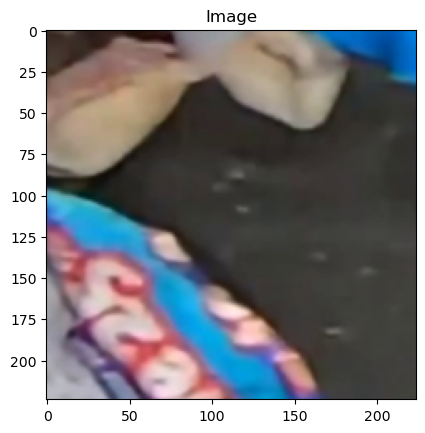

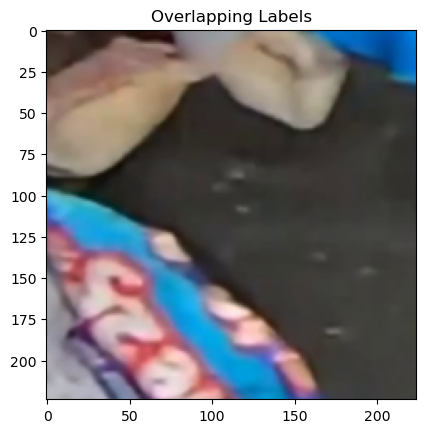

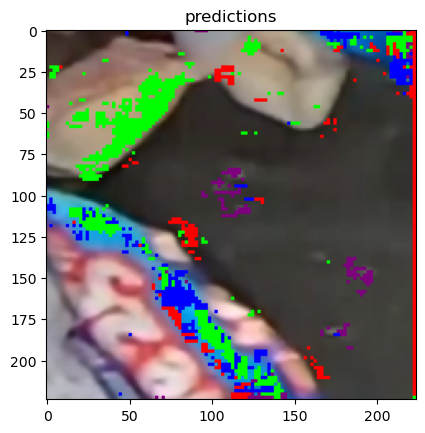

------------------------------------------------------------
For test imgages #61


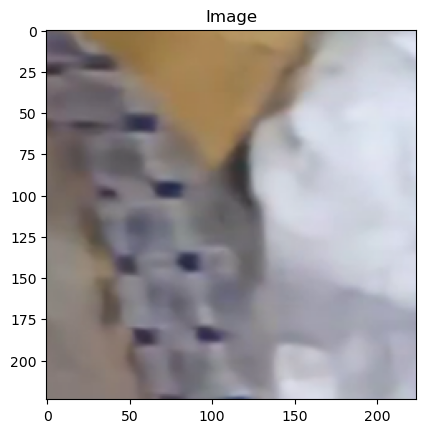

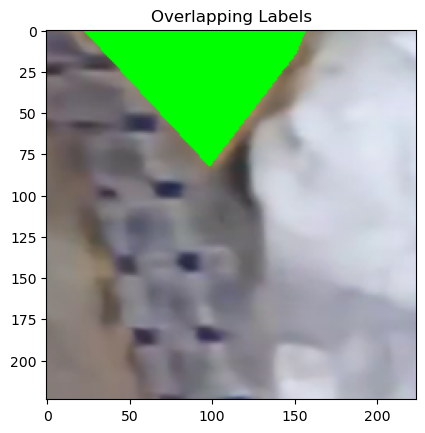

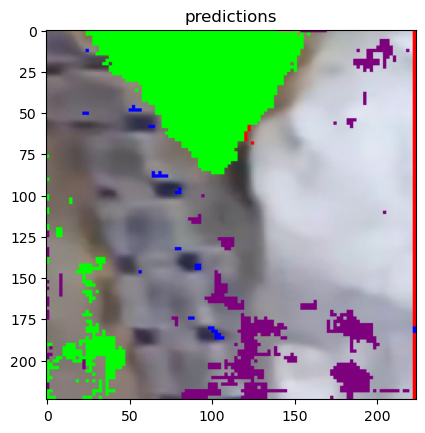

------------------------------------------------------------
For test imgages #71


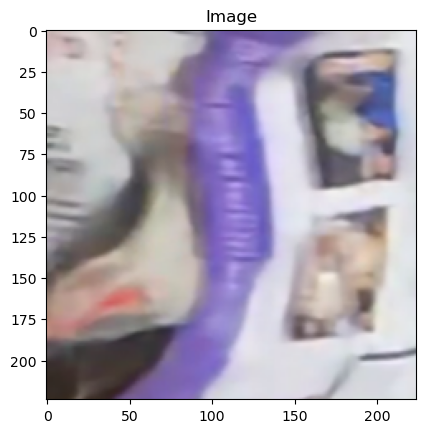

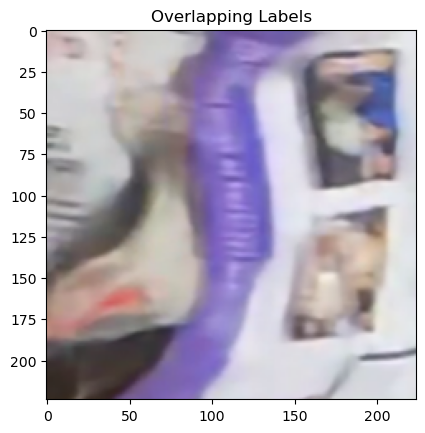

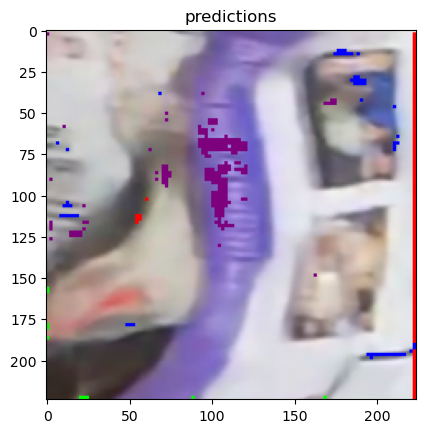

------------------------------------------------------------
For test imgages #81


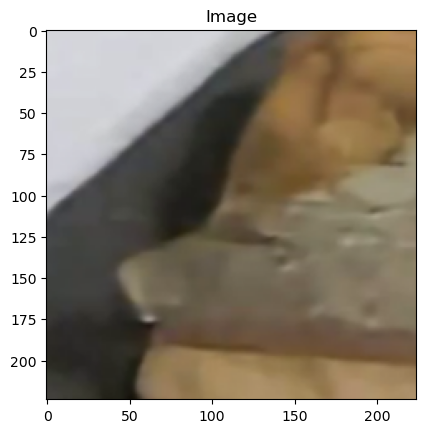

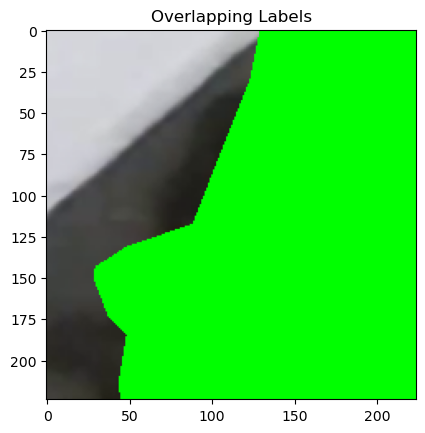

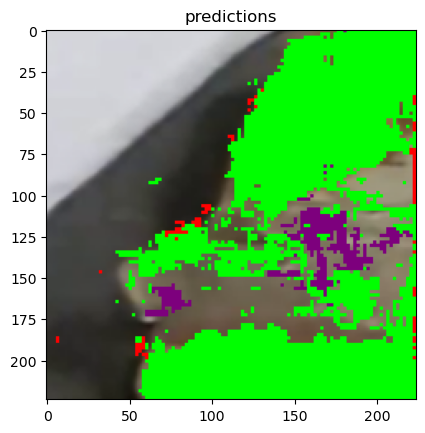

------------------------------------------------------------
For test imgages #91


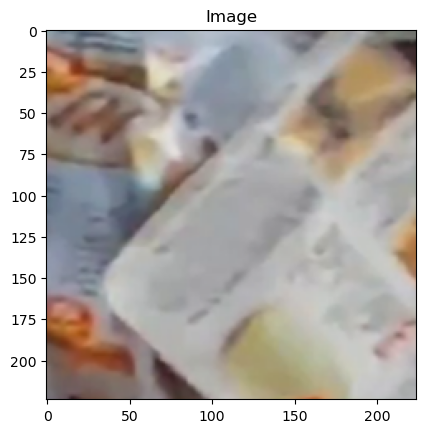

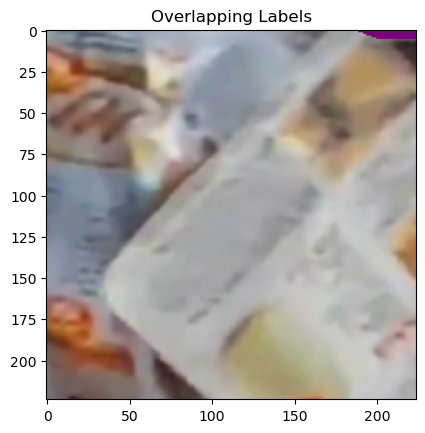

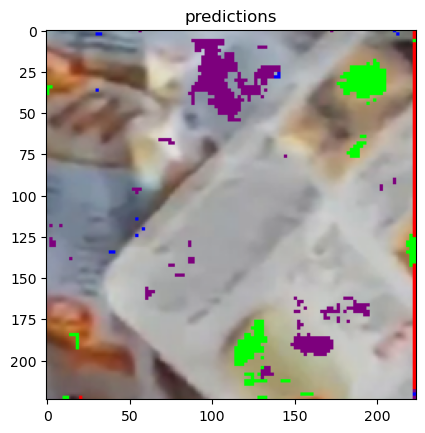

------------------------------------------------------------
For test imgages #101


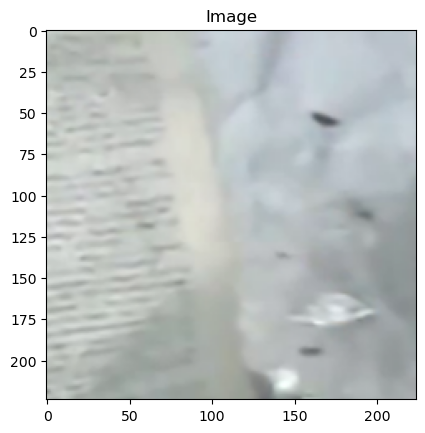

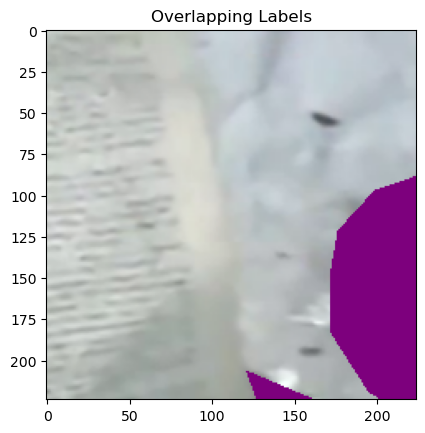

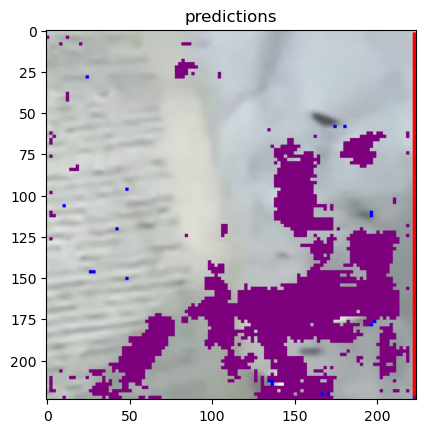

------------------------------------------------------------
For test imgages #111


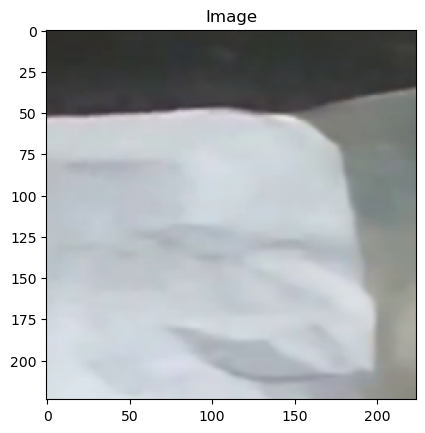

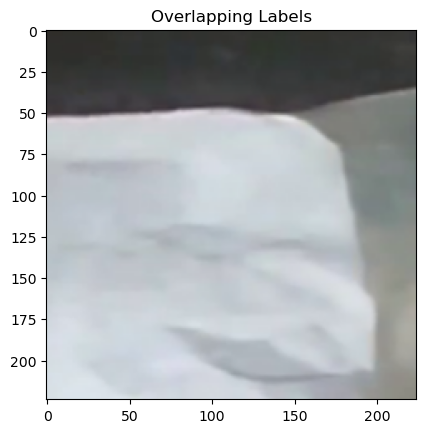

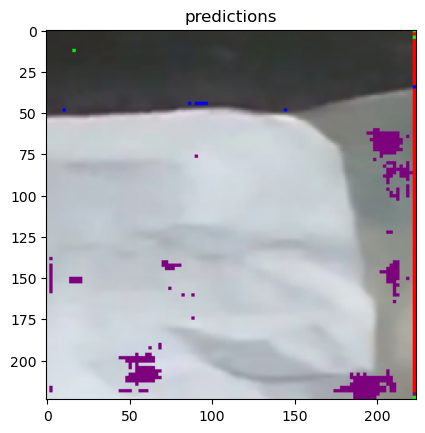

------------------------------------------------------------
For test imgages #121


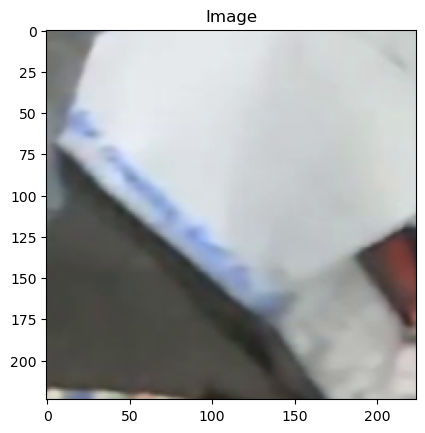

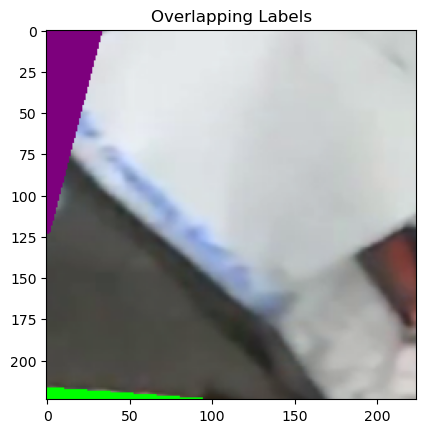

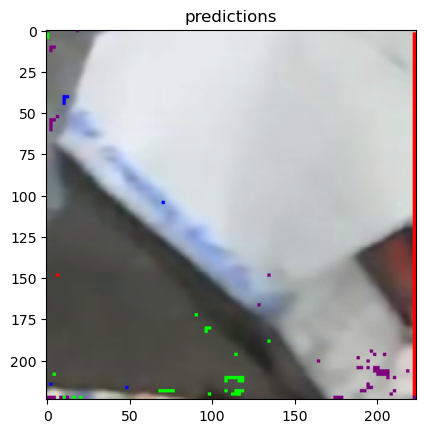

------------------------------------------------------------
For test imgages #131


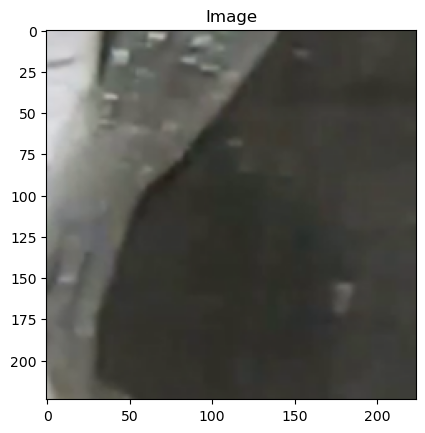

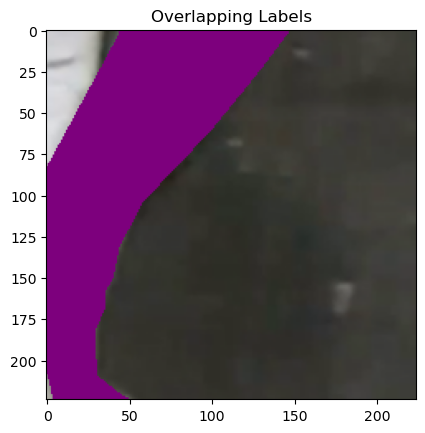

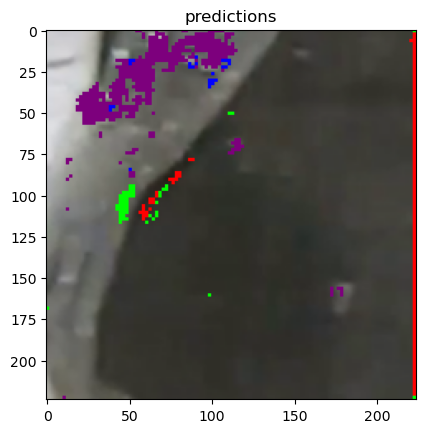

------------------------------------------------------------
For test imgages #141


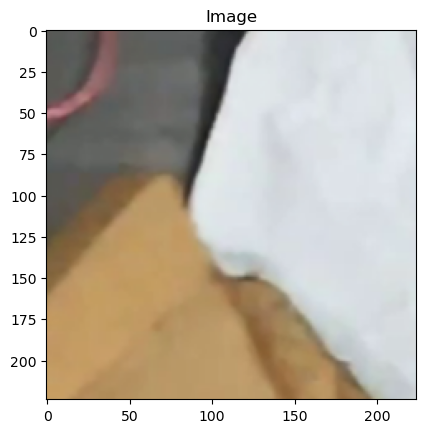

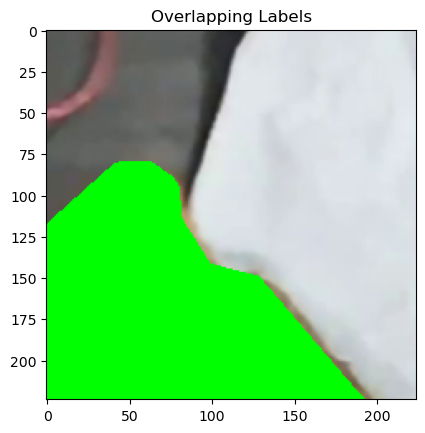

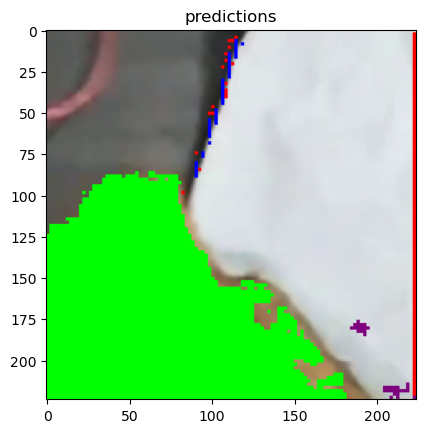

------------------------------------------------------------
For test imgages #151


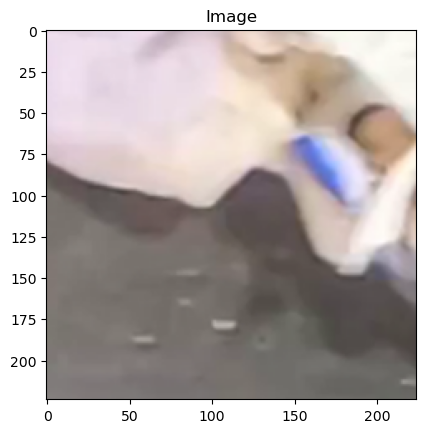

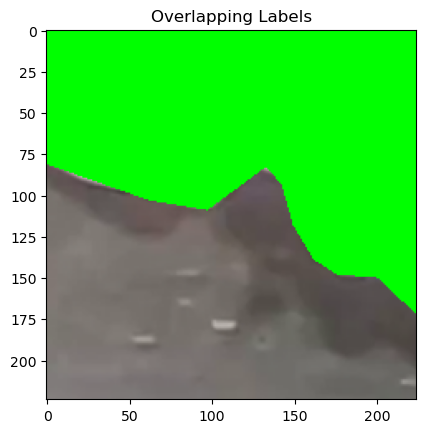

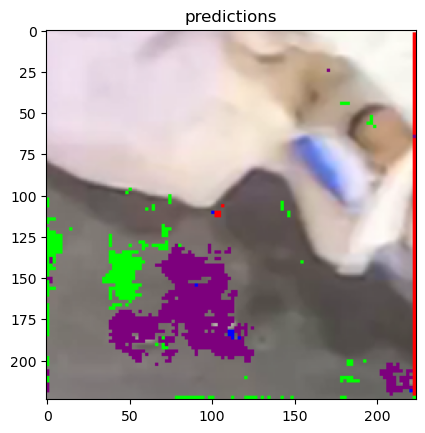

In [21]:
for i in range(0, pred.shape[0], 10):
  print("------------------------------------------------------------\nFor test imgages #" + str(i+1))
  Make_Overlapping_Plot2(x_test[i].astype(np.uint8), y_test[i], pred=pred[i])